In [1]:
import keras
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import os
import pickle
from keras.applications import EfficientNetB4
from keras.models import Model
from tqdm import tqdm

BASE_DIR = 'D:/Yugant Basnet/FYP 30K/FYP Datasets 30K'
WORKING_DIR = 'D:/Yugant Basnet/FYP 30K/FYP Working Dir'
model = keras.models.load_model(WORKING_DIR + '/' + 'model_sub_26.h5')

In [2]:
# Load the tokenizer from the file
with open(WORKING_DIR + '/' + 'tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
print(tokenizer)
vocab_size = len(tokenizer.word_index) + 1

In [3]:
en_model = EfficientNetB4()
en_model = Model(inputs=en_model.inputs, outputs=en_model.layers[-2].output)

In [4]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [5]:
def beam_search_pred(model, image, tokenizer, max_length, K_beams=3, log=False):
    start = tokenizer.texts_to_sequences(['startseq'])[0]
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length).reshape((1, max_length)) # sequence of most probable words
                                                                                         # based on the previous steps
            preds = model.predict([image.reshape(1, -1), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption)
    return final_caption

In [6]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [7]:
def beam_image_preds(image_path, val1, val2):
    max_length = 74
    beam_log = []
        
    img = mpimg.imread(image_path)
    loaded_image = load_img(image_path, target_size=(380, 380))
    image = img_to_array(loaded_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = en_model.predict(image, verbose=0)
    
    beam_X = beam_search_pred(model, feature, tokenizer, max_length, K_beams = val1, log=False)
    beam_Y = beam_search_pred(model, feature, tokenizer, max_length, K_beams = val2, log=False)
    beam_log_X = beam_search_pred(model, feature, tokenizer, max_length, K_beams = val1, log=True)
    beam_log_Y = beam_search_pred(model, feature, tokenizer, max_length, K_beams = val2, log=True)
    beam_log = [beam_X, beam_Y, beam_log_X, beam_log_Y]

    for i in range(len(beam_log)):
        beam_log[i] = beam_log[i].replace("startseq ", "")
    
    return beam_log
    

In [8]:
def fig_plot(image):
    # Load image as a numpy array
    img = plt.imread(image)

    # Create a figure with the desired size in inches
    fig = plt.figure(figsize=(491/80, 321/80))

    # Display the image with the desired aspect ratio
    plt.imshow(img, aspect='equal')

    # Remove axis ticks and labels
    plt.axis('off')

    # Show the figure
    plt.show()

In [9]:
def regular_captions(image_path):
    max_length = 74
    img = mpimg.imread(image_path)
    loaded_image = load_img(image_path, target_size=(380, 380))
    image = img_to_array(loaded_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = en_model.predict(image, verbose=0)
    pred_caption = predict_caption(model, feature, tokenizer, max_length)
    final_caption=(pred_caption.replace("startseq","")).replace("endseq","")
    return final_caption

In [10]:
path = 'D:/Yugant Basnet/FYP 30K/FYP Validiation Data/'

# This will be taken from post request frontend
img_arr = ['123009199_396297708423888_3560677866257014705_n.jpg', '123197842_396298258423833_2402983125063722583_n.jpg']

In [11]:
img = path + img_arr[0]

In [12]:
captioned = regular_captions(img)

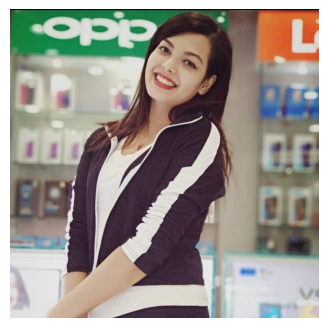

Caption:  woman in black shirt and black jacket is looking at menu 


In [13]:
# Should be handled by frontend
fig_plot(img)
print("Caption:", captioned)

In [14]:
beamed = beam_image_preds(img, 5, 15)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


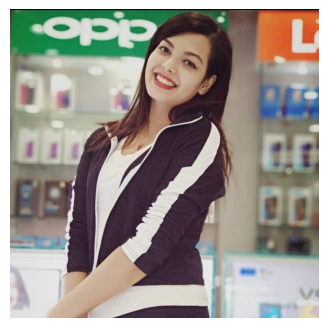

Better Caption 1: woman in black shirt is standing in front of store
Better Caption 2: an asian woman is standing in front of grocery store looking at the menu
Better Caption 3: woman in black shirt is looking at menu
Better Caption 4: woman in black shirt is looking at the menu


In [15]:
# Show in backend
fig_plot(img)
for i in range(len(beamed)):
    print("Better Caption {0}: {1}".format((i+1), beamed[i]))

In [14]:
from gtts import gTTS
from moviepy.editor import AudioFileClip, VideoClip, concatenate_videoclips

In [15]:
# convert text to audio file
text = captioned
tts = gTTS(text=text, lang='en')
tts.save('audio.mp3')


In [16]:
# create video clip with audio file
audio = AudioFileClip('audio.mp3')
video = VideoClip(lambda t: None, duration=audio.duration)
video = video.set_audio(audio)
video.write_videofile('video.mp4', fps=24)


AttributeError: 'NoneType' object has no attribute 'shape'